In [727]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt

In [728]:
def loss_function(recon_x, x, mu, logvar):
    """
    :param recon_x: generated image
    :param x: original image
    :param mu: latent mean of z
    :param logvar: latent log variance of z
    """
    BCE_loss = nn.BCELoss(reduction='sum')
    reconstruction_loss = BCE_loss(recon_x, x)
    KL_divergence = -0.5 * torch.sum(1+logvar-torch.exp(logvar)-mu**2)
    #print(reconstruction_loss, KL_divergence)

    return (reconstruction_loss + KL_divergence)/20

In [729]:
def linear_forward(weight, bias, input):
    pre_acvitation = torch.mm(input, weight)+bias  #(N,784)X(784, 400)
    
    return pre_acvitation    

In [730]:
def linear_backward(weight, bias, input, d_output):
    d_input = torch.mm(d_output, weight.t())  #(1,400)X(400, 784)
    d_weight = torch.mm(input.t(), d_output)/128  #(784,N)X(1, 400)   ？？？
    d_bias = torch.sum(d_output, dim = 0)/128  #（1，400）
    
    return d_weight,d_bias,d_input

In [731]:
def relu_backward(d_output, input):
    d_output = 1/2*(torch.div(input, torch.abs(input))+1)*d_output
    
    return d_output
    

In [732]:
def encode(x, W_1, b_1, W_2_mu, b_2_mu, W_2_logvar, b_2_logvar):
    layer1_output = torch.relu(linear_forward(W_1, b_1, x))
    layer2_output_mu = linear_forward(W_2_mu, b_2_mu, layer1_output)
    layer2_output_logvar = linear_forward(W_2_logvar, b_2_logvar, layer1_output)
    
    return layer1_output, layer2_output_mu,layer2_output_logvar  

In [733]:
def reparametrization(mu, logvar):
    std = torch.exp(logvar/2)
    num_random = torch.rand(std.size())
    z = num_random * std + mu
    
    return z,num_random 

In [734]:
def decode(z,W_3, b_3, W_4, b_4):
    layer3_output = torch.relu(linear_forward(W_3, b_3, z))
    layer4_output = torch.sigmoid(linear_forward(W_4, b_4, layer3_output))
    
    return layer3_output, layer4_output

In [735]:
W_1 = torch.randn(784, 400)/(784*400)
b_1 = torch.zeros((1, 400))/(1*400)
W_2_mu = torch.randn(400, 20)/(20*400)
b_2_mu = torch.zeros((1, 20))/(1*20)
W_2_logvar = torch.randn(400, 20)/(20*400)
b_2_logvar = torch.zeros((1, 20))/(1*20)
W_3 =  torch.randn(20, 400)/(20*400)
b_3 = torch.zeros((1, 400))/(1*400)
W_4 = torch.randn(400,784)/(784*400)
b_4 = torch.zeros((1, 784))/(784*1)

config_W_1 = {}
config_b_1 = {}
config_W_2_mu = {}
config_b_2_mu = {}
config_W_2_logvar = {}
config_b_2_logvar = {}
config_W_3 = {}
config_b_3 = {}
config_W_4 = {}
config_b_4 = {}



Ir = 0.003

# minist数据下载

In [736]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0], [1]),
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

In [737]:
def adam(x, dx, config=None):
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-3)
    config.setdefault('beta1', 0.9)
    config.setdefault('beta2', 0.999)
    config.setdefault('epsilon', 1e-8)
    config.setdefault('m', torch.zeros_like(x))
    config.setdefault('v', torch.zeros_like(x))
    config.setdefault('t', 0)
    next_x = None
    m = config['m']
    v = config['v']
    beta1 = config['beta1']
    beta2 = config['beta2']
    learning_rate = config['learning_rate']
    epsilon = config['epsilon']
    t = config['t']
    t += 1
    m = beta1 * m + (1 - beta1) * dx
    v = beta2 * v + (1 - beta2) * (dx ** 2)
    m_bias = m / (1 - beta1 ** t)
    v_bias = v / (1 - beta2 ** t)
    x += -learning_rate * m_bias / (np.sqrt(v_bias) + epsilon)
    next_x = x
    config['m'] = m
    config['v'] = v
    config['t'] = t

    return next_x, config

<ipython-input-738-35032e2a6c0d>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real_imgs =  torch.tensor(torch.flatten(inputs, start_dim=1))


tensor(923.0269)


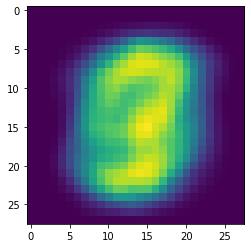

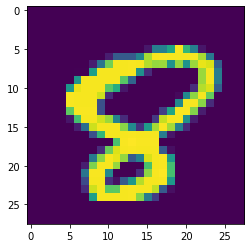

tensor(804.9470)


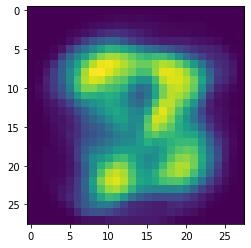

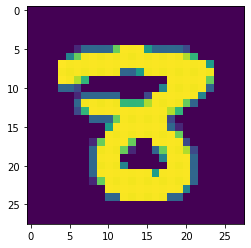

tensor(589.9605)


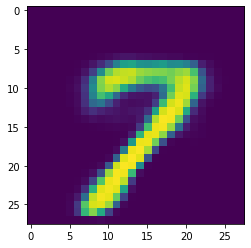

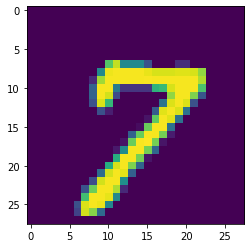

tensor(498.8408)


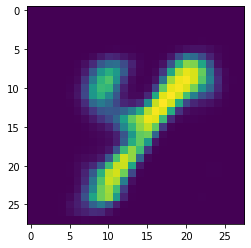

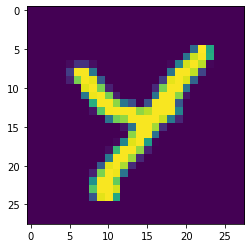

tensor(484.9232)


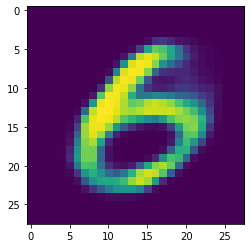

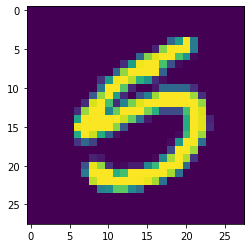

tensor(489.3502)


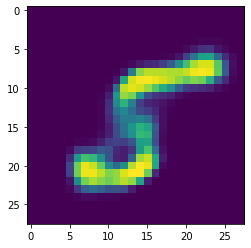

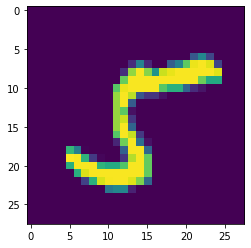

tensor(484.9393)


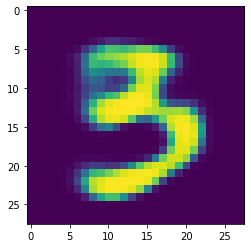

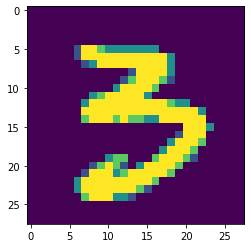

tensor(452.8961)


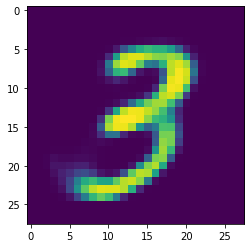

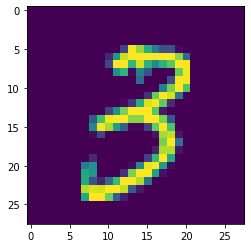

tensor(455.6212)


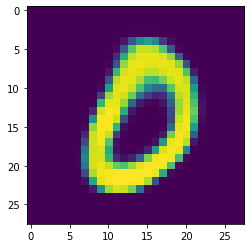

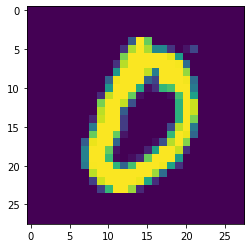

tensor(417.4134)


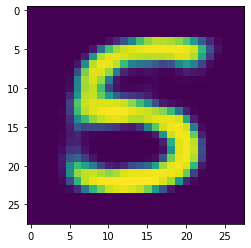

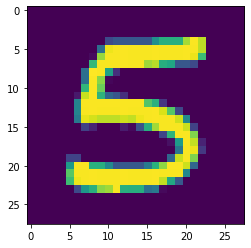

tensor(429.3344)


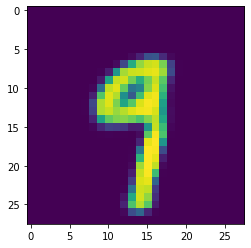

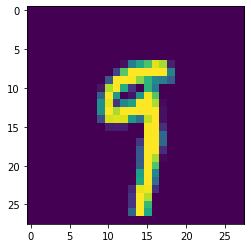

tensor(434.5894)


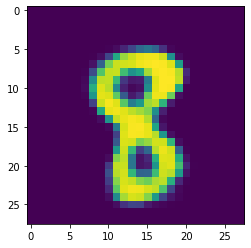

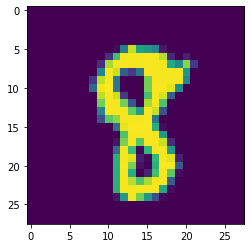

RuntimeError: Assertion `x >= 0. && x <= 1.' failed. input value should be between 0~1, but got -nan(ind) at C:\Users\builder\AppData\Local\Temp\pip-req-build-e5c8dddg\aten\src\THNN/generic/BCECriterion.c:62

In [738]:
for epoch in range(15):
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        #print(batch_idx)
        inputs, targets = inputs.to('cpu'), targets.to('cpu')
        real_imgs =  torch.tensor(torch.flatten(inputs, start_dim=1))
        
        layer1_output, layer2_output_mu,layer2_output_logvar = encode(real_imgs, W_1, b_1, W_2_mu, b_2_mu, W_2_logvar, b_2_logvar)
        z, num_random = reparametrization(layer2_output_mu, layer2_output_logvar)
        layer3_output, gen_imgs = decode(z,W_3, b_3, W_4, b_4)
        
        #print(gen_imgs)
        
        loss = loss_function(gen_imgs, real_imgs, layer2_output_mu, layer2_output_logvar)
        
        d_s = (gen_imgs - real_imgs)/(20*128)  
        d_W_4,d_b_4,d_layer3_output = linear_backward(W_4, b_4, layer3_output, d_s)#torch.relu(d_s)
        d_W_3,d_b_3,d_z =  linear_backward(W_3, b_3, z, relu_backward(d_layer3_output, linear_forward(W_3, b_3, z)))#torch.relu(d_layer3_output)
        d_layer2_output_mu = d_z + layer2_output_mu/(20*128)
        d_layer2_output_logvar = d_z * num_random*np.exp(layer2_output_logvar/2)/2 - 0.5*(1-torch.exp(layer2_output_logvar))/(20*128)  #????
        
        
        d_W_2_mu,d_b_2_mu,d_layer1_ouput_mu = linear_backward(W_2_mu, b_2_mu, layer1_output, d_layer2_output_mu)
        d_W_2_logvar,d_b_2_logvar,d_layer1_ouput_logvar = linear_backward(W_2_logvar, b_2_logvar, layer1_output, d_layer2_output_logvar)
        d_layer1_output = (d_layer1_ouput_mu + d_layer1_ouput_logvar)  #d_layer2_output_mu, d_layer2_output_logvar
        d_W_1,d_b_1,d_real_imgs = linear_backward(W_1, b_1, real_imgs, relu_backward(d_layer1_output, linear_forward(W_1, b_1, real_imgs)))#torch.relu(d_layer1_output)
        
    
        
        W_1, config_W_1 = adam(W_1, d_W_1, config = config_W_1)
        b_1, config_b_1 = adam(b_1, d_b_1, config = config_b_1)
        W_2_mu, config_W_2_mu = adam(W_2_mu, d_W_2_mu, config = config_W_2_mu)
        b_2_mu, config_b_2_mu = adam(b_2_mu, d_b_2_mu, config = config_b_2_mu)
        W_2_logvar, config_W_2_logvar = adam(W_2_logvar, d_W_2_logvar, config = config_W_2_logvar)
        W_3, config_W_3 = adam(W_3, d_W_3, config = config_W_3)
        b_3, config_b_3 = adam(b_3, d_b_3, config = config_b_3)
        W_4, config_W_4 = adam(W_4, d_W_4, config = config_W_4)
        b_4, config_b_4 = adam(b_4, d_b_4, config = config_b_4)       
        
        #W_1 += -Ir * d_W_1
        #b_1 += -Ir * torch.sum(d_b_1, dim = 0)
        #W_2_mu += -Ir * d_W_2_mu
        #b_2_mu += -Ir * torch.sum(d_b_2_mu)
        #W_2_logvar += -Ir * d_W_2_logvar
        #b_2_logvar += -Ir * torch.sum(d_b_2_logvar)
        #W_3 += -Ir * d_W_3
        #b_3 += -Ir * torch.sum(d_b_3)
        #W_4 += -Ir * d_W_4
        #b_4 += -Ir * torch.sum(d_b_4)
        
    print(loss)
    
    fake_images = gen_imgs.view(-1, 1, 28, 28)
    plt.figure()
    plt.imshow(fake_images[0][0])
    plt.show()
    
    images = real_imgs.view(-1, 1, 28, 28)
    plt.figure()
    plt.imshow(images[0][0])
    plt.show()


In [ ]:
    images = real_imgs.view(-1, 1, 28, 28)
    plt.figure()
    plt.imshow(images[5][0])
    plt.show()

In [ ]:
    i = 3
    fake_images = gen_imgs.view(-1, 1, 28, 28)
    plt.figure()
    plt.imshow(fake_images[i][0])
    plt.show()
    
    images = real_imgs.view(-1, 1, 28, 28)
    plt.figure()
    plt.imshow(images[i][0])
    plt.show()
    
    

In [706]:
W_1

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])

In [684]:
layer3_output

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])

In [657]:
relu_backward(torch.tensor([2, 2, 1, 1, 1, 1]), torch.tensor([1, -1, -1, -2, -1,-3]))

tensor([2., 0., 0., 0., 0., 0.])

In [271]:
layer2_output_logvar

tensor([[0.0000e+00, 1.7254e-04, 0.0000e+00,  ..., 7.8387e-05, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 6.0375e-05, 0.0000e+00,
         0.0000e+00],
        [4.9218e-05, 5.4103e-05, 0.0000e+00,  ..., 2.0869e-06, 0.0000e+00,
         6.3551e-06],
        ...,
        [0.0000e+00, 7.5130e-05, 0.0000e+00,  ..., 8.7307e-05, 0.0000e+00,
         0.0000e+00],
        [5.5730e-05, 8.8784e-06, 0.0000e+00,  ..., 3.1905e-05, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 1.6160e-06, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])